# Proyecto Análisis de sentimientos 🤖🎭

 * Daniel Ramírez Vaquero
 * Carlos López Muñoz

 #### En este cuaderno utilizaremos un modelo especializado en detectar *sentimientos* de los comentarios de un juego se Steam.

  1. Para ello utilizaremos un fichero json que contiene la id y el nombre de cada juego de steam.

  2. Una vez tenemos los datos de los juegos, podremos hacer una busqueda interactiva con una aproximación del
  nombre en el cual nos listara las 10 primeras coincidencias.

  3. Si ya conocemos el nombre del juego 🎮 podemos pasar directamente a la extracción de las reviews

  4. Por ultimo pasamos los datos por el trasnformer pipeline para que nos un resultado en función de si el juego es muy bueno, bueno o malo .



### Librerias que se utilizaran :

In [2]:
# Os permite realizar tareas relacionadas con el sistema de archivos y la configuración del entorno.
import os
# Requests ermite enviar solicitudes HTTP de manera sencilla y manejar las respuestas.
import requests
# Json permite convertir entre objetos Python y cadenas JSON.
import json

### Obtención de lista de juegos y su appid.

1. **Verificación de existencia del archivo**:
   - Se comprueba si el archivo `steam-games.json` ya existe en el sistema. Si no existe, se procede a solicitar los datos desde una API.

2. **Solicitud a la API**:
   - Si el archivo no existe, se realiza una solicitud HTTP GET a la API de Steam (`https://api.steampowered.com/ISteamApps/GetAppList/v2/`) para obtener una lista de juegos.

3. **Comprobación de la respuesta**:
   - Se verifica si la solicitud fue exitosa (código de estado HTTP 200).
   
4. **Guardar la respuesta como un archivo JSON**:
   - Si la solicitud fue exitosa, el contenido de la respuesta (en formato JSON) se guarda en el archivo `steam-games.json`.

5. **Manejo de errores**:
   - Si la solicitud no fue exitosa, se imprime un mensaje de error indicando el código de estado recibido.


In [3]:
# Si no tenemos el archivo steam-games.json lo solicitamos a la api y lo generamos.
if not os.path.exists('steam-games.json'):
  # Url del endpoint
  gameListUrl = "https://api.steampowered.com/ISteamApps/GetAppList/v2/"

  # Realizar la solicitud GET
  response = requests.get(gameListUrl)

  # Verificar si la solicitud fue exitosa
  if response.status_code == 200:
    # Obtener el contenido JSON de la respuesta
    data = response.json()

    # Guardar el JSON en un archivo
    with open('steam-games.json', 'w') as file:
      json.dump(data, file)

    # Cierro el archivo
    file.close()
  else:
    print("Error al realizar la solicitud:", response.status_code)

### Buscador para obtener el appid dado el nombre de un juego.

Si ya sabemos el appid del juego podemos saltarnos esta celda e introducirlo en el input de la siguente.

1. **Carga de datos desde un archivo JSON**:
   - Se abre y carga el archivo `steam-games.json`, que contiene la lista de juegos, utilizando la biblioteca `json`.

2. **Búsqueda de coincidencias de nombre de juego**:
   - Se busca en los datos cargados una lista de juegos cuyo nombre comience con el nombre proporcionado por el usuario (`game_name`).
   - Si no se encuentran coincidencias exactas al inicio, se busca el nombre del juego en cualquier parte del nombre del juego.

3. **Solicitar nuevo intento en caso de no encontrar coincidencias**:
   - Si no se encuentran juegos que coincidan con el nombre dado, la función pide al usuario que introduzca un nuevo nombre hasta encontrar coincidencias.

4. **Selección y devolución del `appid`**:
   - Si solo hay una coincidencia exacta, se devuelve el `appid` del juego.
   - Si hay múltiples coincidencias, se muestran las primeras 10 opciones y se solicita al usuario que elija una opción numerada.
   - El `appid` del juego elegido se devuelve si la opción es válida. Si la opción no es válida, se imprime un mensaje de error.

5. **Manejo de errores**:
   - Si no se encuentran coincidencias después de varias búsquedas, o si la opción elegida

In [4]:
def buscar_appid(game_name):
  # Cargar los datos del archivo JSON
  with open('steam-games.json', 'r') as file:
    data = json.load(file)

  # Cerrar el archivo
  file.close()

  # Obtener la lista de juegos
  games = data['applist']['apps']

  # Buscar coincidencias exactas al inicio del nombre
  matches_start = [game for game in games if game['name'].lower().startswith(game_name.lower())]

  # Si no hay coincidencias exactas al inicio, buscar coincidencias en cualquier parte del nombre
  if len(matches_start) == 0:
    matches_contain = [game for game in games if game_name.lower() in game['name'].lower()]
  else:
    matches_contain = []

  matches = matches_start + matches_contain

  # Si no hay coincidencias, solicitar de nuevo
  while len(matches) == 0:
    print("No se encontraron coincidencias exactas. Inténtalo de nuevo.\n")
    game_name = input("Introduce el nombre del juego: ")
    matches_start = [game for game in games if game['name'].lower().startswith(game_name.lower())]
    if len(matches_start) == 0:
      matches_contain = [game for game in games if game_name.lower() in game['name'].lower()]
    else:
      matches_contain = []
    matches = matches_start + matches_contain

  if len(matches) == 1 and matches[0]['name'].lower() == game_name.lower():
    appid = matches[0]['appid']
    print(f"El appid del juego '{game_name}' es: {matches[0]['appid']}")
  else:
    print("Se encontraron varias coincidencias:")
    for i, match in enumerate(matches[:10]):
      if i == len(matches[:10]) - 1:
        print(f"{i + 1}. {match['name']}\n")
      else:
        print(f"{i + 1}. {match['name']}")

    # Solicitar al usuario que elija una opción
    choice = int(input("Elige el número correspondiente al juego: ")) - 1

    # Devolver el appid del juego elegido
    if 0 <= choice < len(matches):
      print(f"El appid del juego '{matches[choice]['name']}' es: {matches[choice]['appid']}")
      appid = matches[choice]['appid']
    else:
      print("Opción no válida.")
      appid = None

  return appid

### Extracción de reviews de dicho juego
Extraemos las reviews más relevantes  de los juegos, extraemos un máximo de **100 reviews**.  

Y su funcionamiento es de la siguiente manera :

1. **Función `obtener_reviews(appid)`**:
   - Realiza una solicitud HTTP a la API de Steam para obtener las reseñas del juego asociado con el `appid` proporcionado.
   - Si la solicitud es exitosa (código de estado 200), devuelve los datos JSON con las reseñas del juego y la URL de la API utilizada.
   - Si la solicitud falla, imprime un mensaje de error y devuelve `None, None`.

2. **Función `solicitar_appid()`**:
   - Solicita al usuario que introduzca un `appid` o el nombre de un juego.
   - Si el usuario introduce un número, se devuelve como `appid`.
   - Si el usuario introduce un nombre, se llama a la función `buscar_appid()` para buscar el `appid` asociado con ese nombre.

3. **Bucle de consulta y verificación**:
   - El bucle principal solicita repetidamente un `appid` o el nombre del juego hasta que el usuario introduce un `appid` válido que tenga reseñas o elige salir (introduciendo `-1`).
   - Si no se encuentran reseñas para el juego, se pide al usuario que intente con otro `appid` o nombre de juego.
   - Si se encuentran reseñas, el número de reseñas cargadas se muestra en pantalla. Si se alcanzan las 100 reseñas, se notifica que se han cargado el máximo posible.

4. **Manejo de salida**:
   - El programa permite salir del bucle introduciendo `-1` como opción de `appid`.

In [5]:
def obtener_reviews(appid):
    gameReviewsUrl = f"https://store.steampowered.com/appreviews/{appid}?json=1&language=english&num_per_page=100"
    response = requests.get(gameReviewsUrl)

    if response.status_code == 200:
        data = response.json()
    else:
        print("Error al realizar la solicitud:", response.status_code)
        return None, None

    return data, gameReviewsUrl

def solicitar_appid():
    choice = input("Introduce el appid del juego o el nombre del juego: ")

    if choice.isdigit():
        return int(choice)
    else:
        return buscar_appid(choice)

# Bucle para solicitar appid o nombre del juego hasta encontrar uno con reviews o el usuario introduzca -1
while True:
    # Solicitar appid o nombre del juego
    appid = solicitar_appid()

    # Verificar si el usuario desea salir
    if appid == -1:
        print("Saliendo del programa.")
        break

    # Obtener reviews
    data, gameReviewsUrl = obtener_reviews(appid)

    # Comprobar si el juego tiene reviews
    if data['query_summary']['total_reviews'] == 0:
        print("El juego no tiene reviews. Por favor, introduce otro appid o busca el appid por el nombre del juego.")
    else:
        reviews = data['reviews']
        num_reviews = len(reviews)
        if num_reviews == 100:
            print(f"Se han cargado {num_reviews} reviews (max).")
        else:
            print(f"Se han cargado {num_reviews} reviews.")
        break


Se han cargado 100 reviews (max).


### Detección de sentimientos
En este apartado analizamos los sentimientos de cada una de las reviews cargadas y finalmente estableceremos un valor promedio para valorar el juego.

In [6]:
#%pip install torch
#%pip install transformers

Importamos la funcion de **pipeline** de la libreria **transformers**.

In [7]:
from transformers import pipeline

cls = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Para finalizar :

1. **Truncamiento de reseñas**:
   - Se limita la longitud de cada reseña a un máximo de 512 caracteres para asegurar que las reseñas no sean demasiado largas para el análisis.

2. **Análisis de sentimiento**:
   - Se utiliza un modelo de clasificación de sentimientos (`cls`) para analizar cada reseña truncada. El resultado del análisis proporciona una etiqueta (`label`) y un puntaje (`score`) que indica la polaridad de cada reseña (positiva, negativa o neutral).

3. **Cálculo del peso de cada sentimiento**:
   - Se calcula el puntaje total para cada categoría de sentimiento (POSITIVE, NEGATIVE, NEUTRAL) sumando los puntajes de todas las reseñas.
   - Se cuenta cuántas reseñas caen en cada categoría.

4. **Cálculo del sentimiento predominante**:
   - Se calcula el sentimiento predominante en base al puntaje total de cada categoría.
   - Si el puntaje positivo es superior al 85%, el sentimiento se considera "MUY POSITIVO", si es superior al 50% pero inferior al 85%, se considera "POSITIVO". El mismo proceso se aplica para los sentimientos negativos y neutrales.

5. **Mostrado de resultados**:
   - Se muestra el sentimiento predominante basado en los resultados del análisis.
   - Se imprime un resumen del conteo de reseñas en cada categoría: positiva, negativa y neutral.

In [8]:
# Truncar las reviews a un máximo de 512 caracteres
max_length = 512
truncated_reviews = [review['review'][:max_length] for review in reviews]

# Obtener los resultados de análisis de sentimiento de cada review
results = [cls(review)[0] for review in truncated_reviews]

# Calculo el peso de cada sentimiento y el conteo de cada categoría
sentiment_scores = {'POSITIVE': 0, 'NEGATIVE': 0, 'NEUTRAL': 0}
sentiment_counts = {'POSITIVE': 0, 'NEGATIVE': 0, 'NEUTRAL': 0}
for result in results:
    label = result['label']
    score = result['score']
    sentiment_scores[label] += score
    sentiment_counts[label] += 1

# Calculo el sentimiento predominante
total_score = sum(sentiment_scores.values())
weighted_sentiment = {k: v / total_score for k, v in sentiment_scores.items()}

# Sacamos un sentimiento medio en forma de texto
if weighted_sentiment['POSITIVE'] >= 0.85:
    overall_sentiment = 'VERY POSITIVE 🎉'
elif weighted_sentiment['POSITIVE'] >= 0.5:
    overall_sentiment = 'POSITIVE 👍🏻'
elif weighted_sentiment['NEGATIVE'] >= 0.85:
    overall_sentiment = 'VERY NEGATIVE 💩'
elif weighted_sentiment['NEGATIVE'] >= 0.5:
    overall_sentiment = 'NEGATIVE 👎🏻'
else:
    overall_sentiment = 'NEUTRAL 🤷🏻‍♀️'

# Mostramos los resultados
print(f"Sentimiento predominante: {overall_sentiment}")
print(f"\nConteo de reviews por categoría:")
print(f"Positivas: {sentiment_counts['POSITIVE']}")
print(f"Negativas: {sentiment_counts['NEGATIVE']}")
print(f"Neutrales: {sentiment_counts['NEUTRAL']}")

Sentimiento predominante: NEGATIVE 👎🏻

Conteo de reviews por categoría:
Positivas: 24
Negativas: 76
Neutrales: 0


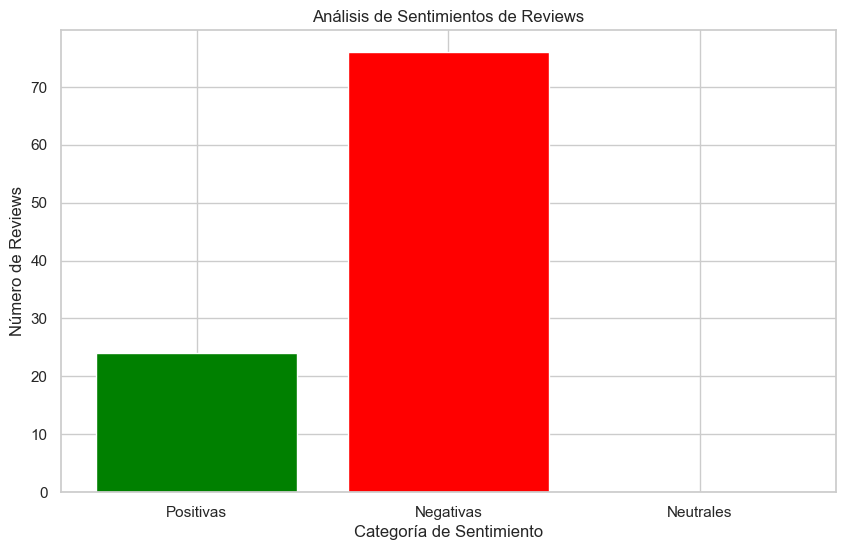

In [14]:
import matplotlib.pyplot as plt

# Datos para la gráfica
labels = ['Positivas', 'Negativas', 'Neutrales']
counts = [sentiment_counts['POSITIVE'], sentiment_counts['NEGATIVE'], sentiment_counts['NEUTRAL']]

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=['green', 'red', 'gray'])
plt.xlabel('Categoría de Sentimiento')
plt.ylabel('Número de Reviews')
plt.title('Análisis de Sentimientos de Reviews')
plt.show()

## *FIN*
